# Fisheries kaggle competition

## 1. Examine data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import numpy as np
import seaborn as sns
sns.set_style()
import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Convolution2D,Flatten,Dropout, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
def onehot(array):
    return to_categorical(array)
USE_SAMPLE=False
if USE_SAMPLE:
    path='data/sample/'
else:
    path='data/'
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [ ]:
# print(len(glob(path+'train_orig/**',recursive=True)))
# print(len(glob(path+'test/**',recursive=True)))
categories=8
# print(categories)

In [ ]:
%matplotlib inline

###  Plots

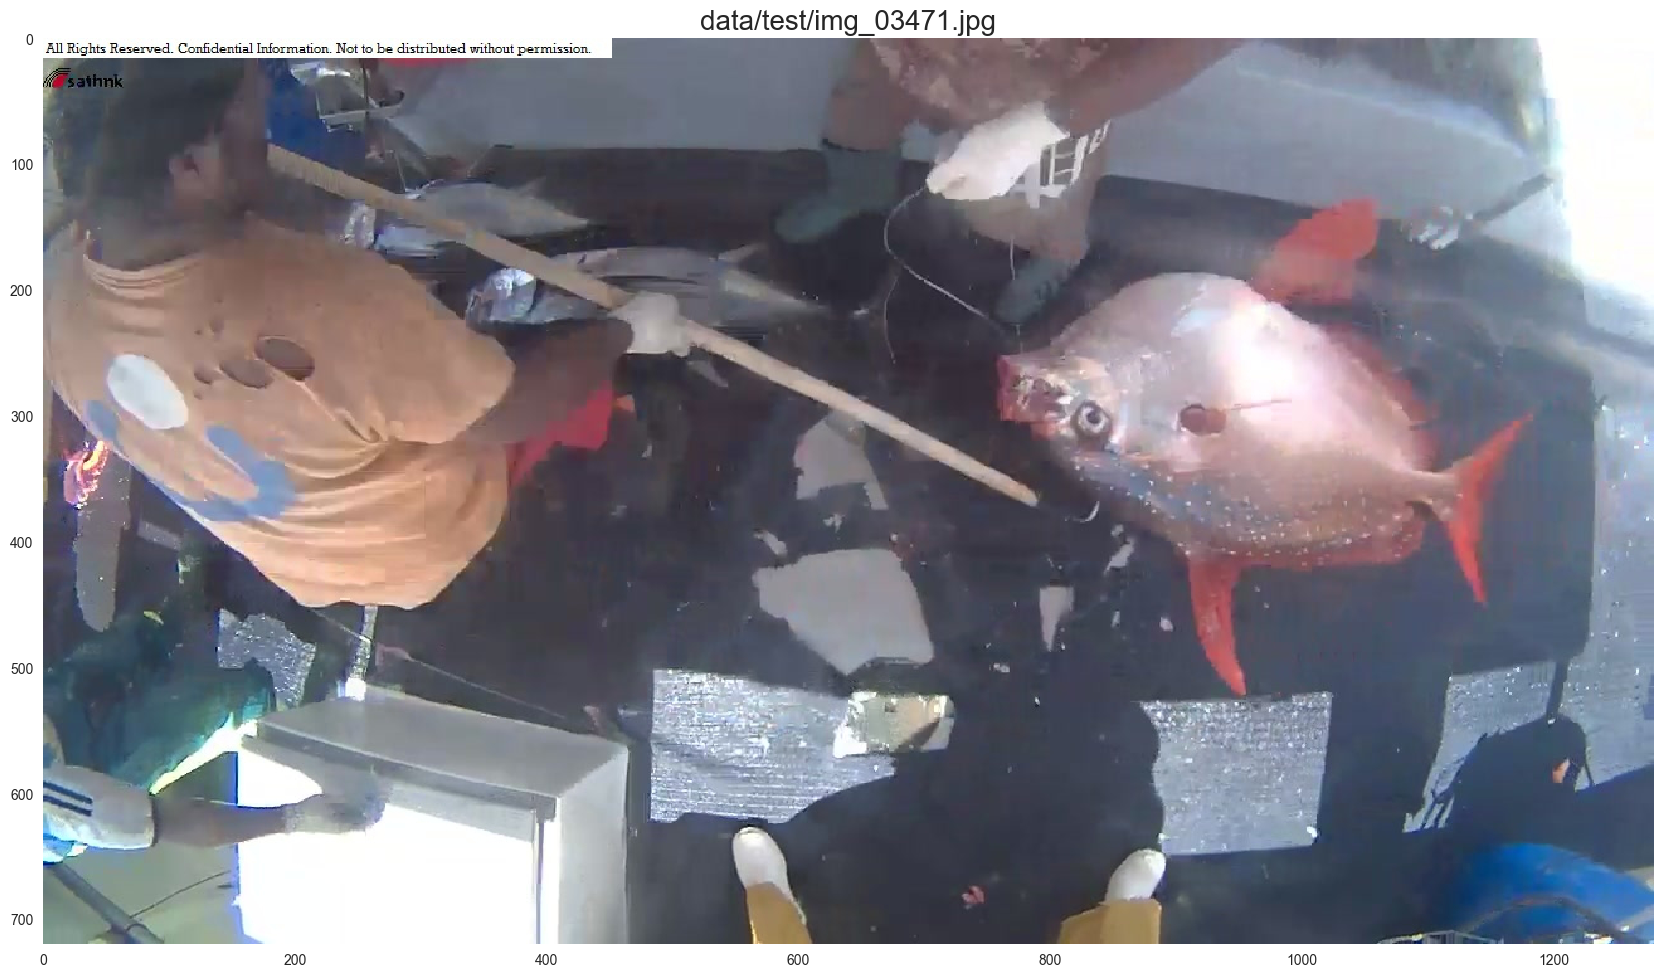

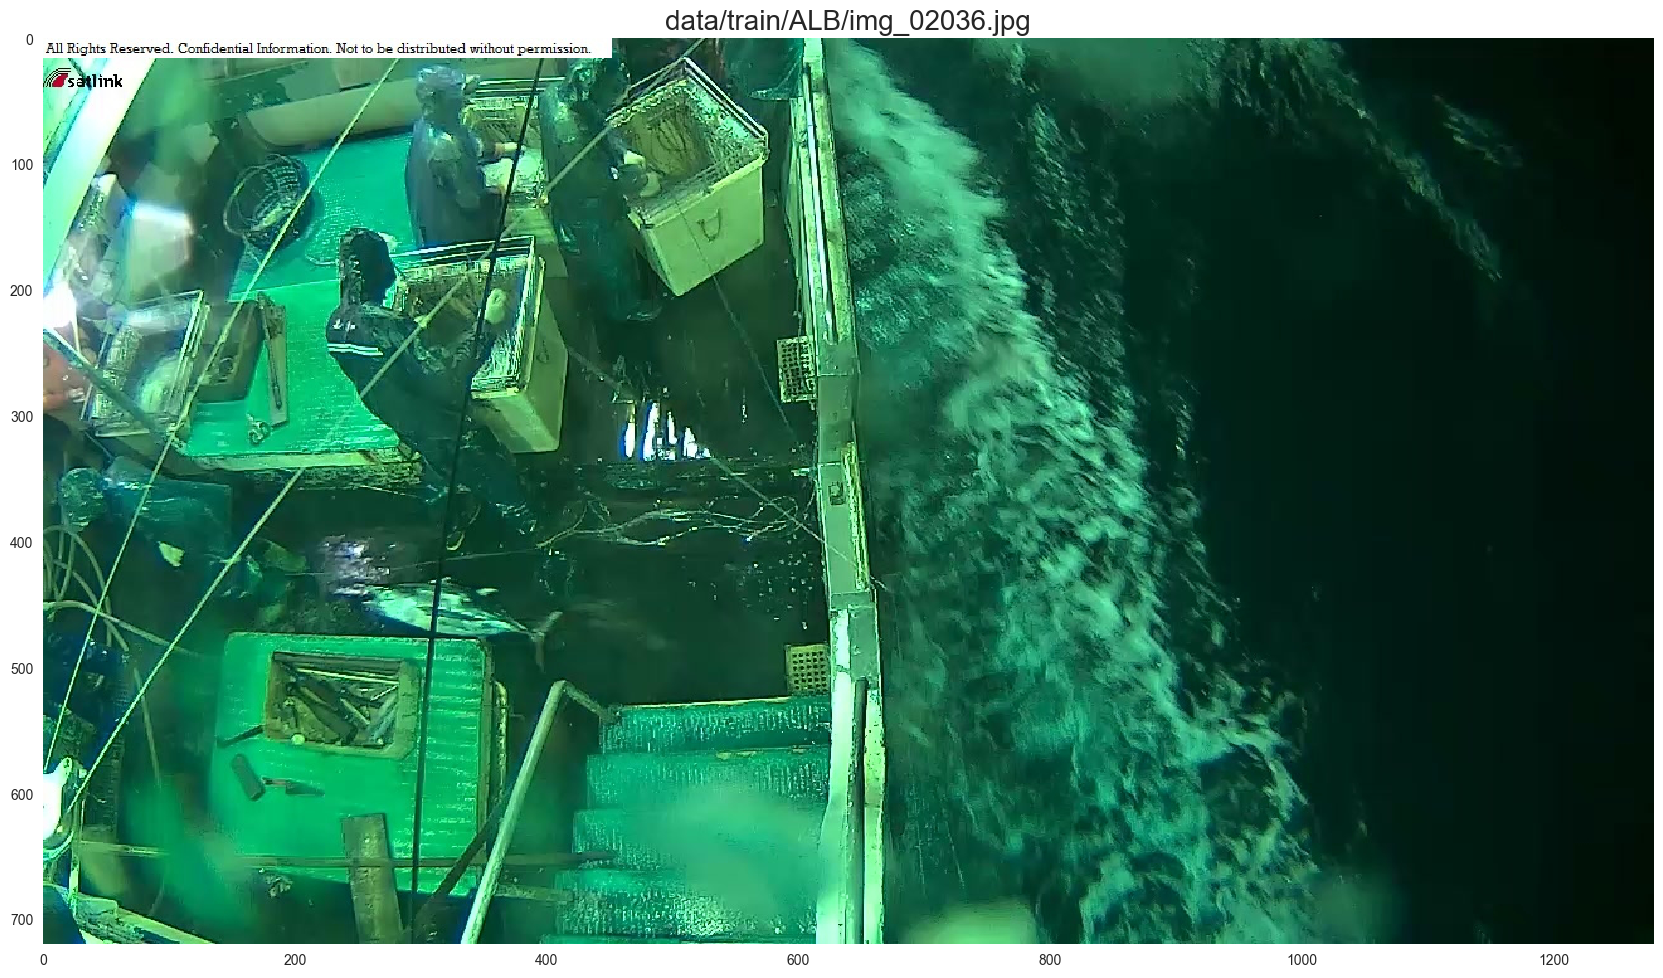

In [17]:
#First, let's have a look at the data
def plot_img(path,n=4):
    """This plots a number of images from a given directory. It can also be fed images directly"""
    imgs=np.random.permutation(glob(path+'*'))[:n]
    fig=plt.figure(figsize=(24,12))
    ns={1:[1,1],2:[1,2],3:[2,2],4:[2,2]}
    for i,img in enumerate(imgs):
        plt.subplot(ns[n][0],ns[n][1],i+1)        
        plt.imshow(mpimg.imread(img))
        plt.gca().grid(False)
        plt.title(imgs[i],fontdict={'fontsize':20})        
plot_img(path+'test/',1)
plot_img(path+'train/ALB/',1)


### Shape 

In [ ]:
#Now, let's see the size of the data. I only do test and assume other data is similar
def get_data_shape(path):
    imgs=np.random.permutation(glob(path+'*'))
    lens=[]
    for img in imgs:
        lens.append(mpimg.imread(img).shape)
    return np.array(lens)
lens_test=get_data_shape(path+'test/')

In [ ]:
# def count_rows(unique_items,array):
#     dic={}
#     for item in unique_items:
#         dic[str(item)]=(array==item).sum()
#     return dic
# def unique_rows(a, **kwargs):

#     rowtype = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
#     b = np.ascontiguousarray(a).view(rowtype)
#     return_index = kwargs.pop('return_index', False)
#     out = np.unique(b, return_index=True, **kwargs)
#     idx = out[1]
#     uvals = a[idx]
#     return uvals
# shapes=count_rows(unique_rows(lens_test),lens_test)
# from pprint import pprint
# pprint(shapes)
# plt.figure(figsize=(12,6))
# plt.bar(range(len(shapes)),shapes.values());
# plt.xticks(range(len(shapes)),[i[:9]+']' for i in shapes.keys()]);
# # Would it make sense to use different nets? Maybe!

## 2. Create sample 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
#path=os.path.realpath('')+'/'+path
# cats/dogs
pre_run=1
samplesize=0.1
prop_train=0.9


if(pre_run==1):
    shutil.rmtree(path+'sample',ignore_errors=1)
    shutil.rmtree(path+'valid',ignore_errors=1)
    shutil.rmtree(path+'train',ignore_errors=1)
    os.mkdir(path+'sample')
    os.mkdir(path+'valid')
    os.mkdir(path+'train')
    os.mkdir(path+'sample/train')
    os.mkdir(path+'sample/test')
    os.mkdir(path+'sample/valid')
    dirs=glob(path+'train_orig/*')
    for i in dirs:        
        subdir=i.split('/')[-1]
        os.mkdir(path+'sample/train/'+subdir)
        os.mkdir(path+'train/'+subdir)
        os.mkdir(path+'sample/valid/'+subdir)
        os.mkdir(path+'valid/'+subdir)
        train,valid=train_test_split(os.listdir(i),train_size=prop_train,random_state=42)
        count=0
        for j in valid:
            if count<=samplesize*len(valid):
                shutil.copy(i+'/'+j,path+'sample/valid/'+subdir+'/'+j)
                count+=1
            shutil.copy(i+'/'+j,path+'valid/'+subdir+'/'+j)
        count=0
        for j in train:
            if count<=samplesize*len(train):
                shutil.copy(i+'/'+j,path+'sample/train/'+subdir+'/'+j)
                count+=1
            shutil.copy(i+'/'+j,path+'train/'+subdir+'/'+j)
    test_imgs=glob(path+'test/*')
    np.random.seed(42)
    sample_test=np.random.permutation(test_imgs)[:round(len(test_imgs)*samplesize)]    
    for i in sample_test:
        shutil.copy(i,path+'sample/test/'+i.split('/')[-1])
        


In [ ]:
# pics=glob(path+'train/**',recursive=True)
# print(len(pics))
# pics=glob(path+'valid/**',recursive=True)
# print(len(pics))
# pics=glob(path+'sample/train/**',recursive=True)
# print(len(pics))
# pics=glob(path+'sample/valid/**',recursive=True)
# print(len(pics))

In [ ]:
gen_train=ImageDataGenerator(rotation_range=10., width_shift_range=0.2, 
       height_shift_range=0.2, shear_range=0.4, zoom_range=0.2, 
       channel_shift_range=6.)
gen_val=ImageDataGenerator()
gen_train=ImageDataGenerator()
batches_train=gen_train.flow_from_directory(path+'train',target_size=(224,224),
                                            batch_size=64,class_mode='categorical')
batches_val=gen_val.flow_from_directory(path+'valid',target_size=(224,224),
                                        batch_size=64,class_mode='categorical',shuffle=False)

## 3. Train simple neural net

In [ ]:

categories=len(glob(path+'train_orig/*'))

model=Sequential([
    BatchNormalization(input_shape=(3,224,224)),
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),    
    Dense(categories,activation='softmax')
])
stop=EarlyStopping(patience=2)
model.compile(Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


#model.load_weights('basic_linear.dat')
def long_train(n):
    model.fit_generator(batches_train,nb_epoch=1,validation_data=batches_val,
                        nb_val_samples=batches_val.N,samples_per_epoch=batches_train.N,callbacks=[stop],verbose=2)
    model.optimizer.lr=1e-3
    model.fit_generator(batches_train,nb_epoch=2,validation_data=batches_val,
                        nb_val_samples=batches_val.N,samples_per_epoch=batches_train.N,callbacks=[stop],verbose=2)
    model.optimizer.lr=1e-2
    model.fit_generator(batches_train,nb_epoch=1,validation_data=batches_val,
                        nb_val_samples=batches_val.N,samples_per_epoch=batches_train.N,callbacks=[stop],verbose=2)
    model.optimizer.lr=1e-4
    model.fit_generator(batches_train,nb_epoch=n,validation_data=batches_val,
                         nb_val_samples=batches_val.N,samples_per_epoch=batches_train.N,callbacks=[stop],verbose=2)
#long_train(20)
#model.load_weights('basic_linear.dat')

In [ ]:
# model.optimizer.lr=0.5e-4
# model.fit_generator(batches_train,nb_epoch=5,validation_data=batches_val,
#                          nb_val_samples=batches_val.N,samples_per_epoch=batches_train.N,callbacks=[stop],verbose=2)


## 4. Train simple convnet

In [ ]:
class miniNet():
    def __init__(self):
        self.lr=1e-4
        self.stop=EarlyStopping(patience=2)
        self.get_model()
    def ConvBlock(self,n):
        model=self.model
        model.add(Convolution2D(n,3,3,activation='relu',border_mode='same'))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.1))
        model.add(Convolution2D(n,3,3,activation='relu',border_mode='same'))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.1))
        model.add(MaxPooling2D())                          
    def FlatBlock(self):
        model=self.model
        model.add(Flatten())
        model.add(BatchNormalization()) 
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.6))
        model.add(BatchNormalization())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.6))
        model.add(BatchNormalization())        
        model.add(Dense(categories,activation='softmax'))
    def get_model(self):
        self.model=Sequential()
        self.model.add(BatchNormalization(input_shape=(3,224,224),axis=1)),
        self.ConvBlock(64)
        self.ConvBlock(128)
        self.FlatBlock()
        self.compile()
        return self.model
    def fit(self,train_batch,val_batch,nb_epoch=1):
       
        self.model.fit_generator(train_batch,nb_epoch=nb_epoch,
                                 validation_data=val_batch,
                                 nb_val_samples=val_batch.N,
                                samples_per_epoch=train_batch.N,verbose=2,callbacks=[self.stop])
    def summary(self):
        self.model.summary()
    def set_lr(self,lr):
        self.lr=lr
        self.model.optimizer.lr=lr
    def compile(self):
        self.model.compile(Adam(lr=self.lr),loss='categorical_crossentropy',metrics=['accuracy'])
     
#CN=miniNet()
#CN.summary()

In [ ]:
#CN.model.save_weights('mini_cnn_1.dat')

In [ ]:
# CN.set_lr(1e-4)
# CN.fit(batches_train,batches_val,1)

# CN.set_lr(1e-3)
# CN.fit(batches_train,batches_val,1)

In [ ]:
# CN.set_lr(1e-4)
# CN.fit(batches_train,batches_val,10)

## 5. Train VGG16bn model

In [ ]:
from vgg16bn import Vgg16BN
vgg=Vgg16BN()
vgg.superfinetune(batches_train)
def get_mod(batches_train):
    mod=Vgg16BN()
    mod.superfinetune(batches_train)
    return mod

In [ ]:
def train(mo):
    mo.fit(batches_train,batches_val,1)
    mo.model.optimizer.lr=1e-3
    mo.fit(batches_train,batches_val,1)
    mo.model.optimizer.lr=1e-4
    mo.fit(batches_train,batches_val,5)
    mo.model.optimizer.lr=0.25e-4
    mo.fit(batches_train,batches_val,20)

In [ ]:
model=vgg.model

### Ensembling

In [ ]:
models = [get_mod(batches_train) for i in range(2)]
for i,m in enumerate(models):
    m.model.load_weights(path+'vgg16-'+str(i)+'.pkl')

In [ ]:
for m in models:
    train(m)

In [ ]:
for i,m in enumerate(models):
    m.model.save_weights(path+'vgg16-'+str(i)+'.pkl')
gen_test=ImageDataGenerator()
   
batches_test=gen_test.flow_from_directory(path+'pretest',target_size=(224,224),
                                            batch_size=64,shuffle=False)
preds=np.array([m.model.predict_generator(batches_test,val_samples=batches_test.N) for m in models])


In [ ]:
preds=preds.mean(axis=0)

## 6. Test and submit

In [ ]:
#gen_test=ImageDataGenerator()
#batches_test=gen_test.flow_from_directory(path+'pretest',target_size=(224,224),
#                                            batch_size=64,shuffle=False)
#preds=model.predict_generator(batches_test,val_samples=batches_test.N)
preds=preds.clip(0.01,0.99)
def name_batch(i):
    return batches_test.filenames[i].split('/')[-1]
def string_array(a):
    return ','.join(str(x) for x in a)
name='sub_vgg2_001_noaugmentation.csv'
with open(name,'w') as f:
    f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for i in range(len(batches_test.filenames)):
        st=name_batch(i)+','+string_array(preds[i])+'\n'
        f.write(st);

        
#os.system('kg submit '+name+'-m `Basic net, more iterations`')

In [ ]:
import IPython.display as dp

dp.display(dp.FileLink(name))


In [ ]:
type('a')==str